In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
portfolio = pd.read_json(r'C:\Desktop\portfolio.json', orient='records', lines=True)
profile = pd.read_json(r'C:\Desktop\profile.json', orient='records', lines=True)
transcript = pd.read_json(r'C:\Desktop\transcript.json', orient='records', lines=True)

In [3]:
df=pd.DataFrame(transcript['value'].values.tolist(),index=transcript.index)

In [4]:
transcript=transcript.merge(df,left_index=True, right_index=True)

In [5]:
#one hot encode channels
mlb = MultiLabelBinarizer()
channel = pd.DataFrame(mlb.fit_transform(portfolio['channels']),columns=mlb.classes_, index=portfolio.index)

In [6]:
portfolio=portfolio.merge(channel,left_index=True, right_index=True)

In [7]:
transcript=transcript.merge(portfolio, left_on='offer_id', right_on='id', how='left')

In [8]:
transcript=transcript.merge(profile, left_on='person', right_on='id', how='left')

In [9]:
agg = (transcript.groupby(['age', 'person'])
         .agg({'person': 'nunique'})
      )
agg.groupby('age')['person'].count()

age
18       70
19      135
20      135
21      140
22      131
       ... 
98        5
99        5
100      12
101       5
118    2175
Name: person, Length: 85, dtype: int64

In [10]:
tran=transcript.groupby('age')['amount'].sum()/agg.groupby('age')['person'].count()
avg_spend_by_age=pd.DataFrame(tran).reset_index()
avg_spend_by_age.columns =['age','avg_dollars_spent']
avg_spend_by_age=avg_spend_by_age[avg_spend_by_age['age']!=118] 
#filter out age 118 because it is an imputation for users with no gender,age, or income

In [11]:
#initial bins in 10 year increment
bins= [18,25,35,45,55,65,75,85,95,105]
labels = ['18-24','25-34','35-44','45-54','55-64','65-74','75-84','85-94','95-101']
avg_spend_by_age['age_group']=pd.cut(avg_spend_by_age['age'], bins=bins, labels=labels, right=False)
avg_spend_by_age

,age,avg_dollars_spent,age_group
0,18,80.465286,18-24
1,19,71.889778,18-24
2,20,76.888148,18-24
3,21,98.846357,18-24
4,22,94.175725,18-24
...,...,...,...
79,97,163.072308,95-101
80,98,74.076000,95-101
81,99,168.376000,95-101
82,100,169.395000,95-101


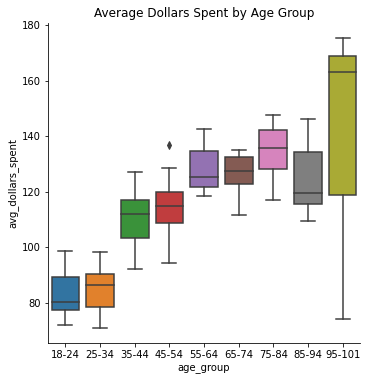

In [12]:
#Slide 7- Starbucks average spend increases with customer age bar chart
sns.catplot(data=avg_spend_by_age, x="age_group", y="avg_dollars_spent",kind='box')
plt.title("Average Dollars Spent by Age Group")
plt.show()

In [13]:
total_members=len(pd.unique(transcript['person']))
paying_members=transcript.groupby('person')['amount'].count()\
                .sort_values(ascending=False).astype(bool).sum(axis=0)
non_paying_members=total_members-paying_members

print("There are",paying_members,"Starbucks members that have spent this month and \n",\
      non_paying_members,"members that have not spent this month.\n")
print("In other words, that is", round(paying_members/total_members*100,1), \
      "percent of the population that are active users \nand",\
     round(non_paying_members/total_members*100,1), "of the population that are inactive users")

There are 16578 Starbucks members that have spent this month and 
 422 members that have not spent this month.

In other words, that is 97.5 percent of the population that are active users 
and 2.5 of the population that are inactive users


In [14]:
d = {'Active Members': [paying_members], 'Inactive Members': [non_paying_members]}
df = pd.DataFrame(data=d)
df=df.T
df.columns=['Number_Members']
df.squeeze()

Active Members      16578
Inactive Members      422
Name: Number_Members, dtype: int64

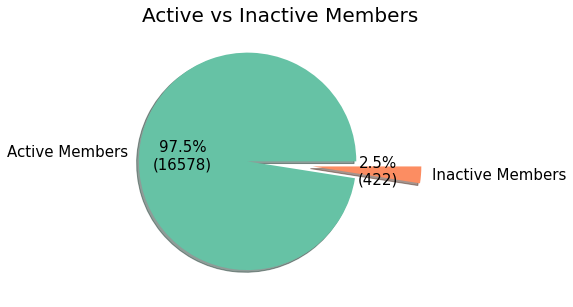

In [15]:
#Slide 10- Opportunity to convert inactive members to active members.
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format
fig1, ax1 = plt.subplots()    
colors = sns.color_palette('Set2')
explode = (0.3, 0.3)  
s = df.squeeze()
fig1.set_size_inches(5,5)
plt.pie(s,labels = s.index, explode=explode, shadow=True,colors=colors, autopct=autopct_format(s),textprops={'fontsize': 15})
fontsize = 20
plt.title('Active vs Inactive Members', fontdict={'fontsize': fontsize})
plt.show()
